This notebook is meant to test that you have all the components you need to run
through the workshop notebooks. It is based on a Kaggle dataset and a Kaggle Kernel
found [here](https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification).

Create a Kaggle account if you don't already have one, then download your Kaggle API key.
Info on how to get your api key (kaggle.json) [here](https://github.com/Kaggle/kaggle-api#api-credentials)
Place the kaggle.json file in the correct directory (~/.kaggle).

Go to the dogs-and-cats competition and accept the rules [here](https://www.kaggle.com/c/dogs-vs-cats/rules).

Run the next cell to initialize the Kaggle API.
If you are running on google colab, then you'll be presented
with a widget. Use it to browse to the kaggle.json file.
(Note: You might have to show hidden files/folders in the file browser)

In [1]:
from pathlib import Path
import os
try:
    # See if we are running on google.colab
    import google.colab
    from google.colab import files
    os.chdir('..')
    if not (Path.cwd() / '.kaggle').is_dir():
        # Configure kaggle
        files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        !pip install -q kaggle
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
    if not (Path.cwd() / 'repo').is_dir():
        # Download the workshop repo and change to its directory
        # For now edit the username/password. This requirement will be removed when the repo is made public.
        !git clone https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
    IN_COLAB = True
except ModuleNotFoundError:
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')
    IN_COLAB = False

The next cell downloads a competition dataset.

If you're running from PyCharm then you may prefer to download it manually in a
terminal/shell/Anaconda prompt because there is no visual feedback in PyCharm (should change in 2019.2).

In [ ]:
!kaggle competitions download -c dogs-vs-cats
import zipfile
for fn in ['train', 'test1']:
    fpath = Path(fn + '.zip')
    with zipfile.ZipFile(fpath, 'r') as zip_ref:
        zip_ref.extractall(Path.cwd() / 'data' / 'dogscats')
    fpath.unlink()
    print("Finished extracting data.")

# Prepare Training Data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt


train_path = Path.cwd() / 'data' / 'dogscats' / 'train'
train_names = os.listdir(train_path)
labels = [_.split('.')[0] for _ in train_names]
classes = [1 if _ == 'dog' else 0 for _ in labels]
df = pd.DataFrame({'filename': train_names, 'label': labels, 'class': classes})
df = df.sample(frac=1).reset_index(drop=True)  # Shuffle rows
df['label'].value_counts().plot.bar()  # Show item counts
plt.show()
df.head()  # Show a few lines of the table

<Figure size 640x480 with 1 Axes>

,filename,label,class
0,cat.2253.jpg,cat,0
1,cat.11862.jpg,cat,0
2,cat.7193.jpg,cat,0
3,dog.9756.jpg,dog,1
4,dog.349.jpg,dog,1


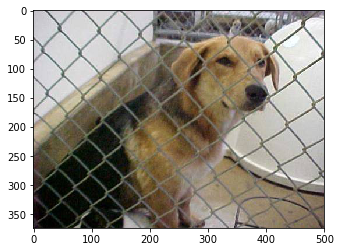

In [3]:
# Display a sample image
import random
from tensorflow.keras.preprocessing.image import load_img


sample = random.choice(train_names)
image = load_img(train_path / sample)
plt.imshow(image)

In [4]:
# Create model
import tensorflow as tf


IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3 # RGB color

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_v

In [5]:
# Prepare callbacks

# import tensorboardcolab as tbc
# tbc_init = tbc.TensorBoardColab()
# tbc_cb = tbc.TensorBoardColabCallback(tbc_init)

earlystop = tf.keras.callbacks.EarlyStopping(patience=10)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [6]:
# Separate train and validation data (0.8, 0.2 respectively)
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
n_train, n_validate, batch_size = train_df.shape[0], valid_df.shape[0], 50

In [7]:
# Create data generators with augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    train_path, 
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    valid_df, 
    Path.cwd() / 'data' / 'dogscats' / 'train', 
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [8]:
# Fit model
history = model.fit_generator(
    train_generator, 
    epochs=5,  # increase to 50 to get some good results
    validation_data=validation_generator,
    validation_steps=n_validate//batch_size,
    steps_per_epoch=n_train//batch_size,
    callbacks=callbacks
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
400/400 [==============================] - 122s 305ms/step - loss: 0.7303 - acc: 0.6473 - val_loss: 1.0124 - val_acc: 0.5250
Epoch 2/50
400/400 [==============================] - 121s 301ms/step - loss: 0.5122 - acc: 0.7486 - val_loss: 0.5703 - val_acc: 0.7462
Epoch 3/50
400/400 [==============================] - 121s 303ms/step - loss: 0.4397 - acc: 0.7997 - val_loss: 0.6343 - val_acc: 0.7288
Epoch 4/50
400/400 [==============================] - 120s 300ms/step - loss: 0.4035 - acc: 0.8173 - val_loss: 0.3783 - val_acc: 0.8298
Epoch 5/50
400/400 [==============================] - 119s 298ms/step - loss: 0.3814 - acc: 0.8302 - val_loss: 0.3590 - val_acc: 0.8498
Epoch 6/50
400/400 [==============================] - 119s 299ms/step - loss: 0.3571 - acc: 0.8438 - val_loss: 0.3164 - val_acc: 0.8668
Epoch 7/50
400/400 [==============================] - 119s 298ms/step - loss: 0.3402 - acc: 0.8507 - val_loss: 0.2983 - val_acc: 0.8816


Epoch 35/50
100/100 [==============================] - 12s 120ms/step - loss: 0.1733 - acc: 0.9306

Epoch 00035: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
400/400 [==============================] - 120s 300ms/step - loss: 0.2016 - acc: 0.9171 - val_loss: 0.1733 - val_acc: 0.9306
Epoch 36/50
400/400 [==============================] - 127s 317ms/step - loss: 0.1989 - acc: 0.9172 - val_loss: 0.1682 - val_acc: 0.9326
Epoch 37/50
100/100 [==============================] - 12s 118ms/step - loss: 0.1693 - acc: 0.9330

Epoch 00037: ReduceLROnPlateau reducing learning rate to 1e-05.
400/400 [==============================] - 123s 309ms/step - loss: 0.2015 - acc: 0.9172 - val_loss: 0.1693 - val_acc: 0.9330
Epoch 38/50
400/400 [==============================] - 123s 307ms/step - loss: 0.2009 - acc: 0.9169 - val_loss: 0.1704 - val_acc: 0.9306
Epoch 39/50
400/400 [==============================] - 123s 308ms/step - loss: 0.1978 - acc: 0.9187 - val_loss: 0.1699 - val_acc: 0

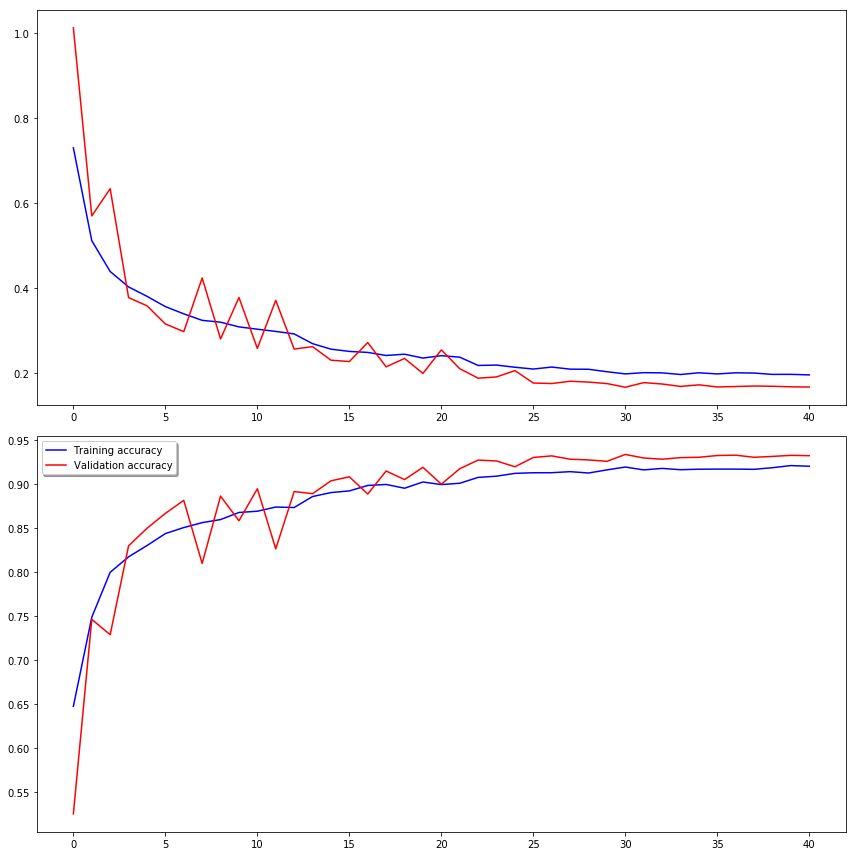

In [9]:
# Visualize Training
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()